This chapter covers
- Preparing text for large language model training
- Splitting text into word and subword tokens
- Byte pair encoding as a more advanced way of tokenizing text
- Sampling training examples with a sliding window approach
- Converting tokens into vectors that feed into a large language model

#### Understanding word embeddings

Deep neural network models, including LLMs, cannot process raw text directly. Since text is categorical, it isn't compatible with the mathematical  operations used to implement and train neural networks. Therefore, we need a way to represent words as **continuous-valued vectors.** The concept of converting data into a vector format is often referred to as **embedding.** 

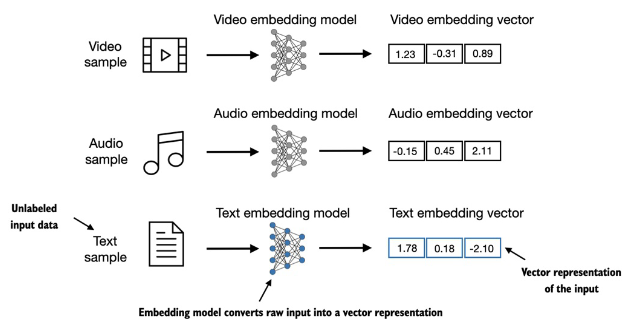

- While word embeddings are the most common form of text embedding, there are also embeddings for sentences, paragraphs, or whole documents. 
- Sentence or paragraph embeddings are popular choices for retrieval- augmented generation. 
- Retrieval-augmented generation combines generation (like producing text) with retrieval (like searching an external knowledge base) to pull relevant information when generating text.

- one old and popular approach - word2vec 
    - NN Architecture by prediting contect of a word fiven the target or vice vrse
    - words appearing in similar context have similar meanings
- LLMs commonly produce their own embeddings that are part of the input layer and are updated during training. 
    - The advantage of optimizing the embeddings as part of the LLM training instead of using Word2Vec is that the embeddings are optimized to the specific task and data at hand.

#### Tokenizing text

split input text into individual tokens, a required preprocessing step for creating embeddings for an LLM
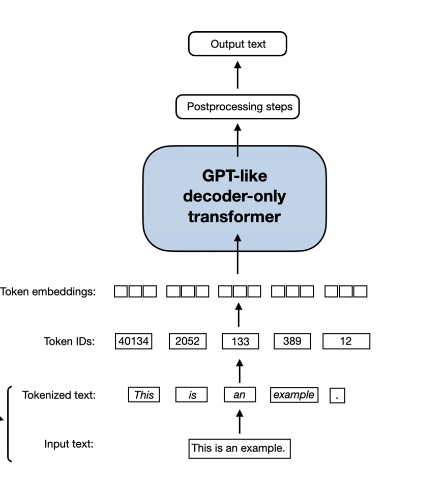

In [6]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [7]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])


Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [8]:
import re
text = raw_text[:99]
result = re.split(r'(\s)', text)

In [9]:
result

['I',
 ' ',
 'HAD',
 ' ',
 'always',
 ' ',
 'thought',
 ' ',
 'Jack',
 ' ',
 'Gisburn',
 ' ',
 'rather',
 ' ',
 'a',
 ' ',
 'cheap',
 ' ',
 'genius--though',
 ' ',
 'a',
 ' ',
 'good',
 ' ',
 'fellow',
 ' ',
 'enough--so',
 ' ',
 'it',
 ' ',
 'was',
 ' ',
 'no',
 ' ',
 '']

In [10]:
result = re.split(r'([,.]|\s)', text)
print(result)

['I', ' ', 'HAD', ' ', 'always', ' ', 'thought', ' ', 'Jack', ' ', 'Gisburn', ' ', 'rather', ' ', 'a', ' ', 'cheap', ' ', 'genius--though', ' ', 'a', ' ', 'good', ' ', 'fellow', ' ', 'enough--so', ' ', 'it', ' ', 'was', ' ', 'no', ' ', '']


In [11]:
result = [item for item in result if item.strip()]
print(result)

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius--though', 'a', 'good', 'fellow', 'enough--so', 'it', 'was', 'no']


Removing whitespaces reduces the memory and computing requirements. However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing).

- Get all tokens
- find the number of unique words
- build a dictionary/vocab list with assigned integer id (sorted based on alphabet)

In [12]:
## apply to full file
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4649


In [13]:
## get all unique words
all_words = sorted(list(set(preprocessed)))
vocab_size = len(all_words)
print(vocab_size)

1159


In [15]:
# build vocab list with sorted
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Carlo;', 25)
('Chicago', 26)
('Claude', 27)
('Come', 28)
('Croft', 29)
('Destroyed', 30)
('Devonshire', 31)
('Don', 32)
('Dubarry', 33)
('Emperors', 34)
('Florence', 35)
('For', 36)
('Gallery', 37)
('Gideon', 38)
('Gisburn', 39)
('Gisburns', 40)
('Grafton', 41)
('Greek', 42)
('Grindle', 43)
('Grindle:', 44)
('Grindles', 45)
('HAD', 46)
('Had', 47)
('Hang', 48)
('Has', 49)
('He', 50)
('Her', 51)


when we want to convert the outputs of an LLM from numbers back into text, we also need a way to turn token IDs into text. For this, we can create an inverse version of the vocabulary that maps token IDs back to corresponding text tokens.

- Create a tokenizer class to convert new text to token ids

In [18]:
# use this vocab list to new text to get a token id assigned
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab #A
        self.int_to_str = {i:s for s,i in vocab.items()} #B
    def encode(self, text): #C
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    def decode(self, ids): #D
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #E
        return text


In [19]:
tokenizer = SimpleTokenizerV1(vocab)

In [24]:
text = "\"It's the last he painted, you know,\" Mrs. Gisburn said"
ids = tokenizer.encode(text)
print(ids)

[1, 58, 2, 872, 1013, 615, 541, 763, 5, 1155, 608, 5, 1, 69, 7, 39, 873]


In [25]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said


##### Applying to new text


In [26]:
text = "Hello, do you like tea?"
tokenizer.encode(text)

KeyError: 'Hello'

The problem is that the word "Hello" was not used in the The Verdict short
story. Hence, it is not contained in the vocabulary. This highlights the need to
consider large and diverse training sets to extend the vocabulary when
working on LLMs.

##### Adding special context tokens

MOdify previous tokenizer to handle new unknown words. Add <|unk|> and <|endoftext|> to handle these new words.

Some of these special tokens are
- [BOS] (beginning of sequence) marks the beginning of text
- [EOS] (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
- [PAD] (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- [UNK] to represent words that are not included in the vocabulary
        
Note that GPT-2 does not need any of these tokens mentioned above but only uses an <|endoftext|> token to reduce complexity
- The <|endoftext|> is analogous to the [EOS] token mentioned above
- GPT also uses the <|endoftext|> for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)
- GPT-2 does not use an <UNK> token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units 
    
- We use the <|endoftext|> tokens between two independent sources of text:




In [27]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab.items()))

1161


In [28]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1156)
('your', 1157)
('yourself', 1158)
('<|endoftext|>', 1159)
('<|unk|>', 1160)


In [29]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text


In [30]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like chai?"
text2 = "Plants on the terrace"

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like chai? <|endoftext|> Plants on the terrace


In [31]:
tokenizer.encode(text)

[1160, 5, 362, 1155, 642, 1160, 10, 1159, 1160, 743, 1013, 1008]

In [32]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like <|unk|>? <|endoftext|> <|unk|> on the terrace'

#####  byte-pair encoding (BPE) 

Since implementing BPE can be relatively complicated, we will use an
existing Python open-source library called tiktoken
(https://github.com/openai/tiktoken), which implements the BPE algorithm
very efficiently based on source code in Rust.


The algorithm underlying BPE breaks down words that aren't in its
predefined vocabulary into smaller subword units or even individual
characters, enabling it to handle out-of-vocabulary words. So, thanks to the
BPE algorithm, if the tokenizer encounters an unfamiliar word during
tokenization, it can represent it as a sequence of subword tokens or
characters

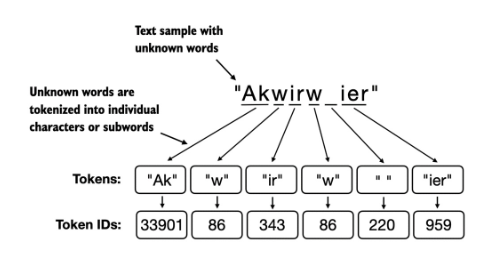

In [33]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [34]:
print(text)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"}) ##missing words are assigned very large id
print(integers)

Hello, do you like chai? <|endoftext|> Plants on the terrace
[15496, 11, 466, 345, 588, 442, 1872, 30, 220, 50256, 39269, 319, 262, 8812, 558]


In [35]:
print(tokenizer.decode(integers))

Hello, do you like chai? <|endoftext|> Plants on the terrace


### Data Sampling with a sliding window

We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict.


In [41]:
## encoding the text file with BPE encoder

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [42]:
# we remove the first 50 tokens from the dataset for demonstration
# purposes as it results in a slightly more interesting text passage in the next
# steps:
enc_sample = enc_text[50:]

One of the easiest and most intuitive ways to create the input-target pairs for
the next-word prediction task is to create two variables, x and y, where x
contains the input tokens and y contains the targets, which are the inputs
shifted by 1

In [43]:
context_size = 4 #number of words in datasample
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1] ## target contains the next word
print(f"x: {x}")
print(f"y: {y}")

x: [290, 4920, 2241, 287]
y: [4920, 2241, 287, 257]


In [49]:
for i in range(1,context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, ">", desired)
    print(tokenizer.decode(context), ">", tokenizer.decode([(desired)]))
    print("--------------")
    

[290] > 4920
 and >  established
--------------
[290, 4920] > 2241
 and established >  himself
--------------
[290, 4920, 2241] > 287
 and established himself >  in
--------------
[290, 4920, 2241, 287] > 257
 and established himself in >  a
--------------


In [50]:
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [51]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader


In [52]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [53]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


### Create token embeddings



In [56]:
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3
torch.manual_seed(2024)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[-1.2262, -0.0093,  0.3700],
        [ 0.4144,  1.8567,  1.9776],
        [-0.4322,  1.3667,  0.7131],
        [-0.3869,  1.6579, -1.3085],
        [ 0.9962,  0.9391,  1.4148],
        [ 0.6343, -0.0776, -1.1175]], requires_grad=True)


We can see that the weight matrix of the embedding layer contains small,
random values. These values are optimized during LLM training as part of
the LLM optimization itself. Moreover,
we can see that the weight matrix has six rows and three columns. There is
one row for each of the six possible tokens in the vocabulary. And there is
one column for each of the three embedding dimensions

the embedding layer
approach above is essentially just a more efficient way of implementing one-
hot encoding followed by matrix multiplication in a fully connected layer

In [57]:
print(embedding_layer(input_ids))

tensor([[-0.4322,  1.3667,  0.7131],
        [-0.3869,  1.6579, -1.3085],
        [ 0.6343, -0.0776, -1.1175],
        [ 0.4144,  1.8567,  1.9776]], grad_fn=<EmbeddingBackward0>)


### Encoding Word Positions

adding positional information to the word embeddings. 2 types of position-aware embeddings 
- relative positional embeddings(distance btw tokens)
- absolute positional embeddings(directly associated with specific pos in seq)

both aim to augment the capacity of LLMs to understand the order and relationshipd btw tokens, ensuring more and accuracte context aware predictions. depends on application and nature of data being processed. 

In [58]:
output_dim = 256
vocab_size = 50257
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)


In [62]:
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [63]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [64]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [65]:
#To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


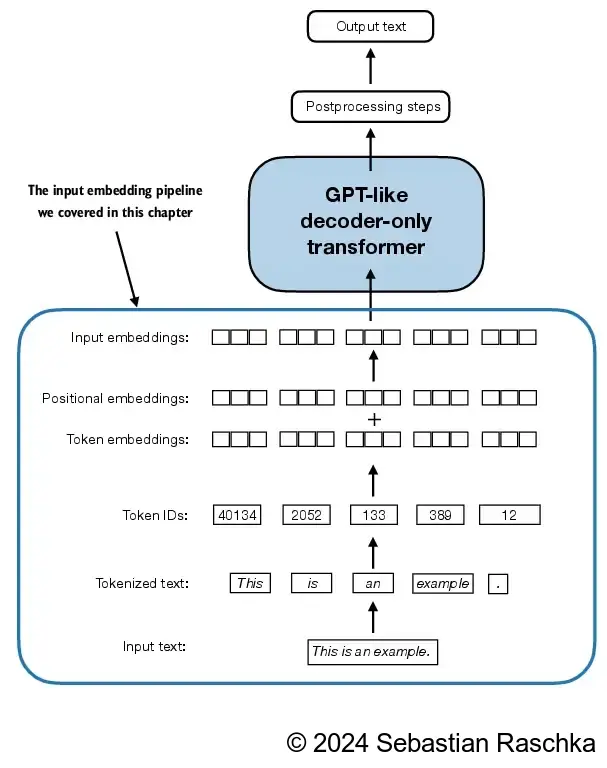

## Exercises

### 2.1


In [37]:
print(tokenizer.encode("Akwirw ier"))

[33901, 86, 343, 86, 220, 959]


In [38]:
print(tokenizer.decode([33901, 86, 343, 86, 220, 959]))

Akwirw ier


In [40]:
print(tokenizer.decode([33901]))
print(tokenizer.decode([86]))
print(tokenizer.decode([343]))
print(tokenizer.decode([86]))
print(tokenizer.decode([959]))

Ak
w
ir
w
ier


### 2.2 
To develop more intuition for how the data loader works, try to run it with
different settings such as max_length=2 and stride=2 and max_length=8 and
stride=2.

In [84]:
##default
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
a,b = next(data_iter)
print(a)
print(b)

print(tokenizer.decode([t.detach().numpy() for t in a][0]))
print(tokenizer.decode([t.detach().numpy() for t in b][0]))

tensor([[  40,  367, 2885, 1464]])
tensor([[ 367, 2885, 1464, 1807]])
I HAD always
 HAD always thought


In [85]:
##
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=10, stride=1, shuffle=False
)

data_iter = iter(dataloader)
a,b = next(data_iter)
print(a)
print(b)

print(tokenizer.decode([t.detach().numpy() for t in a][0]))
print(tokenizer.decode([t.detach().numpy() for t in b][0]))

tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138]])
tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138,   257]])
I HAD always thought Jack Gisburn rather
 HAD always thought Jack Gisburn rather a


In [86]:
##
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=10, stride=4, shuffle=False
)

data_iter = iter(dataloader)
a,b = next(data_iter)
print(a)
print(b)

print(tokenizer.decode([t.detach().numpy() for t in a][0]))
print(tokenizer.decode([t.detach().numpy() for t in b][0]))

tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138]])
tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138,   257]])
I HAD always thought Jack Gisburn rather
 HAD always thought Jack Gisburn rather a


In [87]:
##
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=4, shuffle=False
)

data_iter = iter(dataloader)
a,b = next(data_iter)
print(a)
print(b)

print(tokenizer.decode([t.detach().numpy() for t in a][0]))
print(tokenizer.decode([t.detach().numpy() for t in b][0]))

tensor([[  40,  367, 2885, 1464]])
tensor([[ 367, 2885, 1464, 1807]])
I HAD always
 HAD always thought


In [88]:
##
dataloader = create_dataloader_v1(
    raw_text, batch_size=4, max_length=4, stride=4, shuffle=False
)

data_iter = iter(dataloader)
a,b = next(data_iter)
print(a)
print(b)

print(tokenizer.decode([t.detach().numpy() for t in a][0]))
print(tokenizer.decode([t.detach().numpy() for t in b][0]))

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257]])
tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922]])
I HAD always
 HAD always thought


In [89]:
##
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=10, stride=4, shuffle=False
)

data_iter = iter(dataloader)
a,b = next(data_iter)
print(a)
print(b)

print(tokenizer.decode([t.detach().numpy() for t in a][0]))
print(tokenizer.decode([t.detach().numpy() for t in b][0]))

tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138]])
tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138,   257]])
I HAD always thought Jack Gisburn rather
 HAD always thought Jack Gisburn rather a
